In [130]:
!jupyter nbconvert --to html "/content/AVL_project.ipynb"

[NbConvertApp] Converting notebook /content/AVL_project.ipynb to html
[NbConvertApp] Writing 959997 bytes to /content/AVL_project.html


NB : Certains de nos plot sont intéractifs et ne peuvent pas être compilés en html. Mais ils sont présents dans le rapport .pdf. 

##1. Importing required libraries

In [96]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn import model_selection, preprocessing, metrics
import seaborn as sns # Data Visualisation
import matplotlib.pyplot as plt # Data Visualisation

from scipy import stats


import plotly.offline as plty
from plotly import tools
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot 
import plotly.graph_objs as go 

from wordcloud import WordCloud

import xgboost as xgb
from xgboost import plot_importance
from sklearn import linear_model
from sklearn import ensemble

plt.style.use('ggplot')

from pylab import rcParams
rcParams['figure.figsize'] = (8, 5)

import time 

##2. Loading data

In [97]:
!gdown "https://drive.google.com/uc?id=14b6SaC1v8UDYMBlIYD0ufhHHV70qqddy"

Downloading...
From: https://drive.google.com/uc?id=14b6SaC1v8UDYMBlIYD0ufhHHV70qqddy
To: /content/train_AML.csv
100% 757M/757M [00:05<00:00, 173MB/s]


In [98]:
df=pd.read_csv("/content/train_AML.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.



In [99]:
df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,datasplit,campaign,source,medium,keyword,isTrueDirect,referralPath,adContent,visits,hits,pageviews,bounces,newVisits,transactionRevenue,continent,subContinent,country,region,metro,city,cityId,networkDomain,latitude,longitude,networkLocation,browser,browserVersion,browserSize,operatingSystem,operatingSystemVersion,isMobile,mobileDeviceBranding,mobileDeviceModel,mobileInputSelector,mobileDeviceInfo,mobileDeviceMarketingName,flashVersion,language,screenColors,screenResolution,deviceCategory,criteriaParameters,page,slot,gclId,adNetworkType,isVideoAd
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,train,(not set),google,organic,(not provided),NaN,NaN,NaN,1,1,1.0,1.0,1.0,NaN,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,train,(not set),google,organic,(not provided),NaN,NaN,NaN,1,1,1.0,1.0,1.0,NaN,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,train,(not set),google,organic,(not provided),NaN,NaN,NaN,1,1,1.0,1.0,1.0,NaN,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,train,(not set),google,organic,google + online,NaN,NaN,NaN,1,1,1.0,1.0,1.0,NaN,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available 

##3. EDA and prepocess

In [100]:
# Function to Describe each column

def DataDesc(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 
    
    return summary


In [101]:
DataDesc(df)

Dataset Shape: (903653, 55)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,channelGrouping,object,0,8,Organic Search,Organic Search,Organic Search,2.11
1,date,int64,0,366,20160902,20160902,20160902,8.46
2,fullVisitorId,object,0,723803,1131660440785968503,377306020877927890,3895546263509774583,19.22
3,sessionId,object,0,902755,1131660440785968503_1472830385,377306020877927890_1472880147,3895546263509774583_1472865386,19.78
4,socialEngagementType,object,0,1,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged,0.00
5,visitId,int64,0,886303,1472830385,1472880147,1472865386,19.75
6,visitNumber,int64,0,384,1,1,1,1.43
7,visitStartTime,int64,0,887159,1472830385,1472880147,1472865386,19.75
8,datasplit,object,0,1,train,train,train,0.00
9,campaign,object,0,10,(not set),(not set),(not set),0.32




*   One can notice that there are a lot of columns with only one unique value
*   Columns : isTrueDirect,adContent,isVideoAd,page... contain lot of null values so we will drop thse columns
* Where the target (transactionRevenue) is null it means that no revenue so na in this column will be replace by 0 



In [102]:
#% Of nans by columns

def Null_Count(df):
    df_null = df.isnull().sum().sort_values(ascending = False).rename('Null').reset_index()

    null_count = df_null['Null']
    null_percent = (null_count * 100) / (df.shape[0])

    df_null = pd.concat([df_null['index'],null_count,null_percent], axis=1, keys=['Column','Null_Count','Null_Percent'])

    return df_null[df_null['Null_Count'] != 0]



Null_Count(df)

,Column,Null_Count,Null_Percent
0,adContent,892707,98.788694
1,transactionRevenue,892138,98.725728
2,isVideoAd,882193,97.625195
3,slot,882193,97.625195
4,page,882193,97.625195
5,adNetworkType,882193,97.625195
6,gclId,882092,97.614018
7,isTrueDirect,629648,69.678073
8,referralPath,572712,63.377425
9,keyword,502929,55.655102


In [103]:
#fill nans

def fill_na(df):   
    df['pageviews'].fillna(1, inplace=True)
    df['newVisits'].fillna(0, inplace=True)
    df['bounces'].fillna(0, inplace=True) 
    df["transactionRevenue"].fillna(0.0, inplace=True)
    
    # Changing datatypes from object to desired ones
    df['pageviews'] = df['pageviews'].astype(int)
    df['newVisits'] = df['newVisits'].astype(int)
    df['bounces'] = df['bounces'].astype(int)
    df["transactionRevenue"] = df["transactionRevenue"].astype(float)
    
    
    df['isTrueDirect'].fillna(False, inplace=True) 
    df['isVideoAd'].fillna(True, inplace=True) # filling boolean with True
    return df

df=fill_na(df)

In [104]:
#Removing columns with uniques values
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
print(f'Columns : {constant_columns}, \n Num of Columns : {len(constant_columns)}')
df.drop(constant_columns, axis=1, inplace=True)

Columns : ['socialEngagementType', 'datasplit', 'visits', 'cityId', 'latitude', 'longitude', 'networkLocation', 'browserVersion', 'browserSize', 'operatingSystemVersion', 'mobileDeviceBranding', 'mobileDeviceModel', 'mobileInputSelector', 'mobileDeviceInfo', 'mobileDeviceMarketingName', 'flashVersion', 'language', 'screenColors', 'screenResolution', 'criteriaParameters'], 
 Num of Columns : 20


In [105]:
Null_Count(df)
df.drop(list(Null_Count(df)['Column']), axis=1,inplace=True)

##4. Data Viz

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 0, 'Revenue')

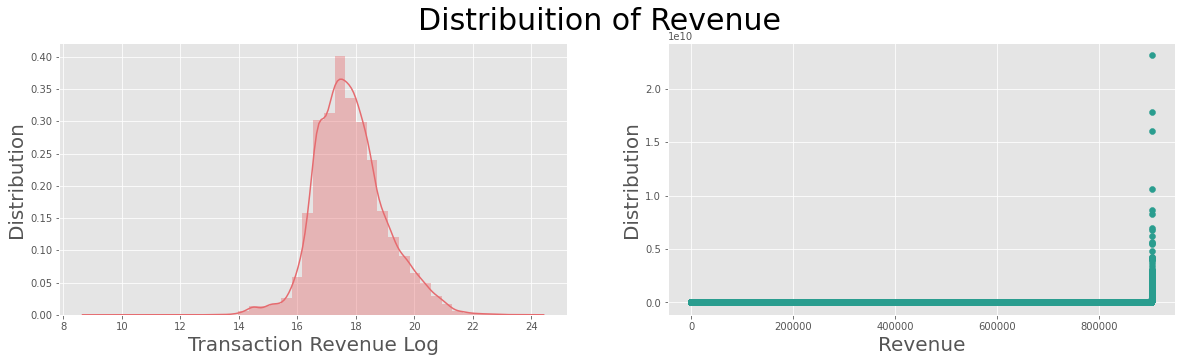

In [106]:
fig = plt.figure(figsize=(20,5))
plt.suptitle('Distribuition of Revenue', fontsize=30)

ax1 = fig.add_subplot(121)
_ = sns.distplot(np.log(df[df['transactionRevenue'] > 0]["transactionRevenue"]), bins=40,color='#e56b6f', ax=ax1)
ax1.set_ylabel('Distribution', fontsize=20)
ax1.set_xlabel('Transaction Revenue Log', fontsize=20)


ax2 = fig.add_subplot(122)
_ = plt.scatter(range(df.shape[0]), np.sort(df['transactionRevenue'].values), color='#2a9d8f')
ax2.set_ylabel('Distribution', fontsize=20)
ax2.set_xlabel('Revenue', fontsize=20)

These graphs illustrae perfectly the pareto principle (also known as the 80/20 rule or the law of the vital few) that it states that in many cases, roughly 80% of the effects of action comes from 20% of the causes. In our case 80% of revenues are generated by 20% of visitors.

In [107]:
group = df.groupby(['channelGrouping','browser']).size().rename('Count').reset_index()

group_sorted = group.groupby(['channelGrouping']).apply(lambda x: x.sort_values(['Count'], ascending=False)).reset_index(drop=True)

group_top_four = group_sorted.groupby(['channelGrouping']).head(4)

colors = ["#264653","#2a9d8f","#e9c46a","#f4a261","#e76f51",'#457b9d']
px.bar(data_frame=group_top_four,x='channelGrouping',y='Count', color='browser', template='plotly_white', color_discrete_sequence= colors,width=700)

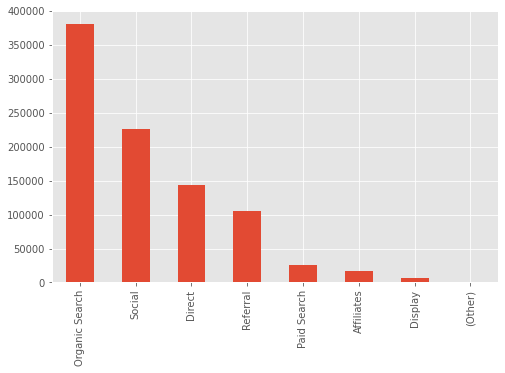

In [108]:
#Wich channel did user visited ? 
df['channelGrouping'].value_counts().plot.bar()
plt.show()

### Browser 

In [109]:
#function to count by a column and calculate the mean revenue for each distinct values of this column
def count_mean(col,color1,color2):
    col_count = df[col].value_counts()
    col_count_chart = go.Bar(x = col_count.head(10).index, y = col_count.head(10).values, name="Count",marker = dict(color=color1))

    col_mean_count = df[[col,'transactionRevenue']][(df['transactionRevenue'] >1)]
    col_mean_count = col_mean_count.groupby(col)['transactionRevenue'].mean().sort_values(ascending=False)
    col_mean_count_chart = go.Bar(x = col_mean_count.head(10).index, y = col_mean_count.head(10).values, name="Mean",marker = dict(color=color2))
    fig = tools.make_subplots(rows = 1, cols = 2,subplot_titles=('Total Count','Mean Revenue'))
    fig.append_trace(col_count_chart, 1,1)
    fig.append_trace(col_mean_count_chart,1,2)
    plty.iplot(fig,image_width=100)

In [110]:
count_mean('browser',"#7FDBFF","#3D9970")

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



* The user visit count is very high for Chrome but Firefox users have genereted more revenue

### Device Category

In [111]:
count_mean('deviceCategory',"#FF851B","#FF4136")

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead





*   Desktop site has generated more user count as well as more revenue
*   One thing to note is tablet users have generated almost same revenue as mobile users



### operating system

In [112]:
count_mean('operatingSystem',"#80DEEA","#0097A7")

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead





*   Less chrome OS users but high revenue is generated. -For windows phone users also generated good revenue.




### Source where users

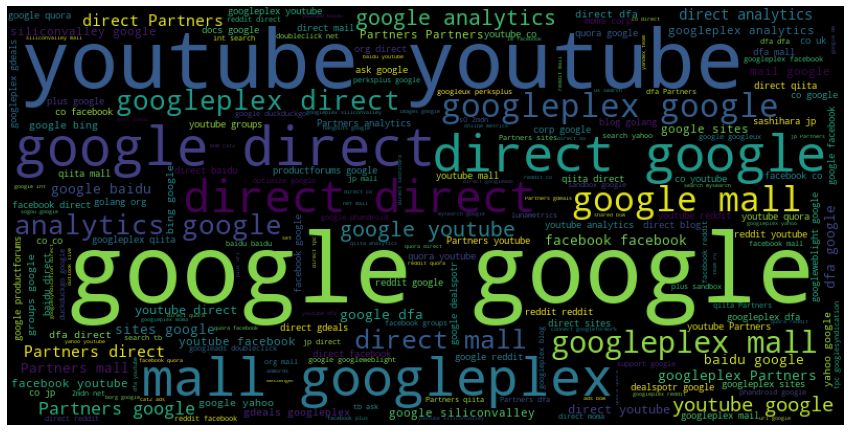

In [113]:
df['source'] = df['source'].fillna('')
wordcloud2 = WordCloud(width=800, height=400).generate(' '.join(df['source']))
plt.figure( figsize=(15,20) )
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

##5. Modelling

In [114]:
# label encode the categorical variables and convert the numerical variables to float
cat_cols = list(df.select_dtypes(include='object').columns)

for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(df[col].values.astype('str')) + list(df[col].values.astype('str')))
    df[col] = lbl.transform(list(df[col].values.astype('str')))

channelGrouping
fullVisitorId
sessionId
campaign
source
medium
continent
subContinent
country
region
metro
city
networkDomain
browser
operatingSystem
deviceCategory


In [115]:
#Finally let's see what our dataset looks like 
DataDesc(df)

Dataset Shape: (903653, 28)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,channelGrouping,int64,0,8,4,4,4,2.11
1,date,int64,0,366,20160902,20160902,20160902,8.46
2,fullVisitorId,int64,0,715119,14742,223090,232669,19.19
3,sessionId,int64,0,902755,101785,340201,351204,19.78
4,visitId,int64,0,886303,1472830385,1472880147,1472865386,19.75
5,visitNumber,int64,0,384,1,1,1,1.43
6,visitStartTime,int64,0,887159,1472830385,1472880147,1472865386,19.75
7,campaign,int64,0,10,0,0,0,0.32
8,source,int64,0,380,149,149,149,2.41
9,medium,int64,0,7,5,5,5,1.78


In [116]:
def rmse(y_true, y_pred):
    return round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)), 5)



<a href="url"><img src="https://www.boost.org/doc/libs/1_62_0/libs/math/doc/graphs/log1p.svg" align="left" height="300" width="500" ></a>


* If x is in range 0...+Inf then it will never cause an error (as we know log(0) would cause an error).

In [117]:
from sklearn.model_selection import train_test_split

X, y = df.loc[:,df.columns!="transactionRevenue"],np.log1p(df.loc[:,"transactionRevenue"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=176740)

### Defining Models

In [118]:
def create_random_forest():
  model=ensemble.RandomForestRegressor(n_estimators = 100, oob_score = True, n_jobs = -1,random_state =50,max_features = "sqrt", min_samples_leaf = 50)
  return model


In [119]:
def create_reg_linear():
  return linear_model.LinearRegression()

In [120]:
def create_model_xgboost(X_train,y_train,X_val=None,y_val=None):
    params = {'objective': 'reg:linear',
              'eval_metric': 'rmse',
              'eta': 0.001,
              'max_depth': 10,
              'subsample': 0.6,
              'colsample_bytree': 0.6,
              'alpha':0.001,
              'random_state': 42,
              'silent': True}

    xgb_train_data = xgb.DMatrix(X_train, y_train)
   

    model = xgb.train(params, xgb_train_data, 
                      num_boost_round=100, 
                      evals= [(xgb_train_data, 'train')],
                      early_stopping_rounds=100, 
                      verbose_eval=500
                     )

    y_pred_train = model.predict(xgb_train_data, ntree_limit=model.best_ntree_limit)

    print(f"RMSE train: {rmse(y_train, y_pred_train)}")
    return  model

### Defining Training and Evaluation Methods

In [121]:
model1=create_reg_linear()
model1.fit(X_train,y_train)
pred1=model1.predict(X_test)
rmse(y_test,pred1)

1.81929

In [122]:
model2=create_random_forest()
model2.fit(X_train,y_train)
pred2=model2.predict(X_test)
rmse(y_test,pred2)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



1.66204



*   Xgboosting




In [123]:
xgb_model = create_model_xgboost(X_train, y_train, X_test)

[0]	train-rmse:2.01787
Will train until train-rmse hasn't improved in 100 rounds.
[99]	train-rmse:1.96064
RMSE train: 1.96064


### Tuning

Since random forest regression gave us the best rmse, we decide to tune this model





1.   Random Hyperparameter Grid










In [124]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap} 

random_grid

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [125]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = ensemble.RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available scores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 2, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train[:25000], y_train[:25000])

Fitting 2 folds for each of 5 candidates, totalling 10 fits


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(), n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [126]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 200}

In [127]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    r=rmse(y_test,predictions)
    print('Model Performance')
    print(f'rmse: {r}')
    return r

base_model = ensemble.RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model,X_test, y_test)

Model Performance
rmse: 1.74281


In [128]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
rmse: 1.69838


In [129]:
print('Improvement of {:0.2f}%.'.format( 100 * (abs(random_accuracy - base_accuracy)) / base_accuracy))

Improvement of 2.55%.
